[課題のURL](https://diver.diveintocode.jp/curriculums/1877)

# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク2

In [35]:
import numpy as np
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

* データセットをダウンロード

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
#print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)


* 平滑化

In [4]:
# X_train = X_train.reshape(-1, 784)
# X_test = X_test.reshape(-1, 784)
# print(X_train.shape)
# print(y_train.shape)

* 前処理

画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0
print(X_train.shape)
print(X_test.shape)

1.0
0.0
(60000, 28, 28)
(10000, 28, 28)


In [6]:
# X_train[0] # 0から1の値

正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。  
scikit-learnのOneHotEncoderを使用したコードが以下です。  
このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。  

In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


さらに、訓練データ6万枚の内2割を検証データとして分割してください。  
訓練データが48000枚、検証データが12000枚となります。  

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 28, 28)
(12000, 28, 28)


In [9]:
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [10]:
print(y_train_one_hot[0])
print(y_train_one_hot[1])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


# 2次元の畳み込みニューラルネットワークスクラッチ

今回はこれを任意の層数に拡張しやすいものに書き換えていきます。  
その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。  

* ミニバッチ処理

ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。  
分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。  

In [11]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [12]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
#print(len(get_mini_batch)) # 2400
#print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

In [13]:
X_train.shape

(48000, 28, 28)

In [14]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [15]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [16]:
def im2col_slow(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for move_y in range(out_h):
        for move_x in range(out_w):
            for y in range(filter_h):
                for x in range(filter_w):
                    col[:, :, y, x, move_y, move_x] = \
                        img[:, :, y + stride * move_y, x + stride * move_x]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

# 【問題1】2次元畳み込み層の作成

~~~
class Conv2d:
        def __init__(self, w, b, optimizer, stride=1, pad=0):
            self.optimizer = optimizer
            
            self.W = w
            self.B = b
            self.stride = stride
            self.pad = pad

            # 中間データ（backward時に使用）
            self.x = None   
            self.col = None
            self.col_W = None

            # 重み・バイアスパラメータの勾配
            self.dW = None
            self.db = None

        def _N_out_h(self, H, FH):
            # H:入力データの高さ、FH:フィルタの高さ
            return (1 + int((H + 2*self.pad - FH) / self.stride))

        def _N_out_w(self, W, FW):
            # W:入力データの高さ、FW:フィルタの高さ
            return (1 + int((W + 2*self.pad - FW) / self.stride))

        def forward(self, x):
            # xのIFを4次元に変更する
            # x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])

            N, C, H, W = x.shape # N:データ数, C:チャネル数、H:データの高さ、W:データの幅
            FN, C, FH, FW = self.W.shape # FN:フィルタ数、C:チャネル数、FH:フィルタの高さ、FW:フィルタの幅
            
            # 一つあたりの出力データのサイズ(畳み込み後のサイズ)を求める
            out_h = self._N_out_h(H, FH)
            out_w = self._N_out_w(W, FW)
            #print("出力データのサイズ")
            #print(out_h, out_w)

            # 演算を行うため2次元のデータに変換する
            col = im2col(x, FH, FW, self.stride, self.pad)
            col_W = self.W.reshape(FN, -1).T

            # 畳み込み処理
            out = np.dot(col, col_W) + self.B

            # 畳み込み処理の結果を任意の次元に変換 C:チャンネル1の場合
            out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
            # out = out.transpose(1, 0) 

            # backward処理のためにデータ保存
            self.x = x
            self.col = col
            self.col_W = col_W

            #print("Nanの確認", np.sum(x), np.sum(col), np.sum(col_W))
            
            return out

        def backward(self, dout):
            FN, C, FH, FW = self.W.shape # FN:フィルタ数、C:チャネル数、FH:フィルタの高さ、FW:フィルタの幅

            # C:チャンネル1の場合
            dout = dout.transpose(0,2,3,1).reshape(-1, FN)
            #dout =  out.transpose(1, 0)

            self.db = np.sum(dout, axis=0)
            self.dW = np.dot(self.col.T, dout)
            self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

            dcol = np.dot(dout, self.col_W.T)
            dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

            # パラメータを更新
            # print("self.dW, self.dbの確認:更新前", np.sum(self.dW), np.sum(self.db))
            self = self.optimizer.update(self, self.dW, self.db)
            # print("self.dW, self.dbの確認:更新後", np.sum(self.dW), np.sum(self.db))
    
            return dx
~~~

# 【問題2】2次元畳み込み後の出力サイズ

~~~ 
def _N_out_h(self, H, FH):
    # H:入力データの高さ、FH:フィルタの高さ
    return (1 + int((H + 2*self.pad - FH) / self.stride))

def _N_out_w(self, W, FW):
    # W:入力データの高さ、FW:フィルタの高さ
    return (1 + int((W + 2*self.pad - FW) / self.stride))
~~~

# 【問題3】最大プーリング層の作成

~~~
class Pooling:
        def __init__(self, pool_h, pool_w, stride=1, pad=0):
            self.pool_h = pool_h
            self.pool_w = pool_w
            self.stride = stride
            self.pad = pad

            self.x = None
            self.arg_max = None

        def forward(self, x):
            # xのIFを4次元に変更する
            # x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
            
            N, C, H, W = x.shape
            out_h = int(1 + (H - self.pool_h) / self.stride)
            out_w = int(1 + (W - self.pool_w) / self.stride)

            col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
            col = col.reshape(-1, self.pool_h*self.pool_w)

            arg_max = np.argmax(col, axis=1)
            out = np.max(col, axis=1)
            out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

            self.x = x
            self.arg_max = arg_max
            
            return out

        def backward(self, dout):
            dout = dout.transpose(0, 2, 3, 1)

            pool_size = self.pool_h * self.pool_w
            dmax = np.zeros((dout.size, pool_size))
            dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
            dmax = dmax.reshape(dout.shape + (pool_size,)) 

            dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
            dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

            return dx
~~~

# 【問題4】（アドバンス課題）平均プーリングの作成

# 【問題5】平滑化

~~~
class Flatten:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.x_shape = None
    
    def forward(self, x):
        self.x_shape = x.shape
        
        # 4dを次の層に渡すため1次元に変換
        x_flatten = x.reshape(-1, x.shape[1]*x.shape[2]*x.shape[3])
        return x_flatten
    
    def backword(self, x):
        # 平滑化したデータを4dに変換
        dZ1_4d = x.reshape(batch_size, self.x_shape[1], self.x_shape[2], self.x_shape[3])
        
        return dZ1_4d
~~~

# 【問題6】学習と推定

In [6]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    N層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, epoch = 5, alpha = 0.001, activation='sigmoid', optimizer="SGD", init="simple" ,verbose = True):
        self.verbose = verbose
        
        self.epoch = epoch
        self.batch_size = 20 # バッチサイズ
        
        self.n_features = 784 # 特徴量の数
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 100
        self.n_output = 10 # 出力のクラス数（3層目のノード数）
        
        self.init_type = init # 初期化方法
        self.activation_type = activation # 活性化関数
        self.optimizer_type = optimizer # 最適化方法
        
        self.sigma = 0.01 # ガウス分布の標準偏差
        self.lr = alpha

    def _encode_10(self, data):
        t = np.zeros((data.size, 10))
        for i in range(data.size):
            t[i, data[i]] = 1
        return t

    def _calc_loss(self, y, z):
        # エントロピー誤差を求める
        # 0割回避のため(z=0を防ぐため)
        delta = 1e-7
        n = y.shape[0]

        l = -1/n*np.sum(y*np.log(z+delta))

        return l
    
    class sigmoid:
        def __init__(self):
            self.out = None
        
        def _sigmoid(self, x):
            sigmoid_range = 34.538776394910684
            x = np.clip(x, -sigmoid_range, sigmoid_range)
            return 1.0/(1.0+np.exp(-x))
        
        def forward(self, x):
            y = self._sigmoid(x)
            self.out = y
            
            return y

        def backward(self, dz):
            dA = dz*(1 - self.out)*(self.out)
            
            return dA
    
    class ReLU:
        def __init__(self):
            self.mask = None

        def forward(self, x):
            self.mask = (x <= 0)
            x_out = x.copy()
            x_out[self.mask] = 0

            return x_out

        def backward(self, x):
            x[self.mask] = 0
            dx = x

            return dx
    
    class activation_softmax:
        def __init__(self):
            self.y = None
            self.t = None # one-hot
            
        def _softmax(self, x):
            n = x.shape[0]

            sigmoid_range = 34.538776394910684
            x = np.clip(x, -sigmoid_range, sigmoid_range)
            
            for i in range(n):
                exp_x = np.exp(x[i])
                sum_exp_x = np.sum(exp_x)
                x[i] = exp_x/sum_exp_x

            return x
        
        def forward(self, x):
            self.y = self._softmax(x)
            
            return self.y

        def backward(self, z, t):
            d = z - t
            
            return d
    
    class SimpleInitializer:
        def __init__(self, sigma):
            self.sigma = sigma
        def W(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
            return W
        
        def B(self, n_nodes1, n_nodes2):
            # n_nodes2は使用しないが、他の初期化関数とIFを合わせる
            np.random.seed(1)
            b = self.sigma * np.random.randn(n_nodes2)
            return b

    class XavierInitializer:
        def __init_(self):
        # 何もしない
            pass
    
        def W(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            W = (1/np.sqrt(n_nodes1)) * np.random.randn(n_nodes1, n_nodes2)
            return W
        
        def B(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            b = (1/np.sqrt(n_nodes1)) * np.random.randn(n_nodes2)
            return b
    
    class HeInitializer:
        def __init_(self):
            # 何もしない
            pass

        def W(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            W = np.sqrt(2/n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
            return W

        def B(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            b = np.sqrt(2/n_nodes1) * np.random.randn(n_nodes2)
            return b
    
    class SGD:
        def __init__(self, lr=0.001):
            self.lr = lr
        def update(self, layer, dw, db):
            layer.W = layer.W - self.lr*dw
            layer.B = layer.B - self.lr*db
            
            return layer
    
    class AdaGrad:
        def __init__(self, lr=0.001):
            self.lr = lr
            self.hw = None
            self.hb = None

        def update(self, layer, dw, db):
            if (self.hw is None) or (self.hb is None):
                self.hw = np.zeros_like(dw)
                self.hb = np.zeros_like(db)

            self.hw = self.hw + (dw*dw)
            layer.W = layer.W - self.lr*dw/(np.sqrt(self.hw) + 1e-7)

            self.hb = self.hb + (db*db)
            layer.B = layer.B - self.lr*db/(np.sqrt(self.hb) + 1e-7)
         
            return layer
    
    class FC:
        def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
            self.optimizer = optimizer
            
            self.W = initializer.W(n_nodes1, n_nodes2)
            self.B = initializer.B(n_nodes1, n_nodes2)
            self.x = None
            self.dw = None
            self.db = None
            
        def forward(self, x):
            self.x = x
            return (np.dot(x, self.W) + self.B )

        def backward(self, dout):
            dw = np.dot((self.x).T, dout)
            db = np.sum(dout, axis=0)
            
            # パラメータを更新
            self = self.optimizer.update(self, dw, db)
            
            # 前の層に渡す
            dZ = np.dot(dout, (self.W).T)
            
            return dZ
        
    class Convolution:
        def __init__(self, w, b, optimizer, stride=1, pad=0):
            self.optimizer = optimizer
            
            self.W = w
            self.B = b
            self.stride = stride
            self.pad = pad

            # 中間データ（backward時に使用）
            self.x = None   
            self.col = None
            self.col_W = None

            # 重み・バイアスパラメータの勾配
            self.dW = None
            self.db = None

        def _N_out_h(self, H, FH):
            # H:入力データの高さ、FH:フィルタの高さ
            return (1 + int((H + 2*self.pad - FH) / self.stride))

        def _N_out_w(self, W, FW):
            # W:入力データの高さ、FW:フィルタの高さ
            return (1 + int((W + 2*self.pad - FW) / self.stride))

        def forward(self, x):
            # xのIFを4次元に変更する
            # x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])

            N, C, H, W = x.shape # N:データ数, C:チャネル数、H:データの高さ、W:データの幅
            FN, C, FH, FW = self.W.shape # FN:フィルタ数、C:チャネル数、FH:フィルタの高さ、FW:フィルタの幅
            
            # 一つあたりの出力データのサイズ(畳み込み後のサイズ)を求める
            out_h = self._N_out_h(H, FH)
            out_w = self._N_out_w(W, FW)
            #print("出力データのサイズ")
            #print(out_h, out_w)

            # 演算を行うため2次元のデータに変換する
            col = im2col(x, FH, FW, self.stride, self.pad)
            col_W = self.W.reshape(FN, -1).T

            # 畳み込み処理
            out = np.dot(col, col_W) + self.B

            # 畳み込み処理の結果を任意の次元に変換 C:チャンネル1の場合
            out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
            # out = out.transpose(1, 0) 

            # backward処理のためにデータ保存
            self.x = x
            self.col = col
            self.col_W = col_W

            #print("Nanの確認", np.sum(x), np.sum(col), np.sum(col_W))
            
            return out

        def backward(self, dout):
            FN, C, FH, FW = self.W.shape # FN:フィルタ数、C:チャネル数、FH:フィルタの高さ、FW:フィルタの幅

            # C:チャンネル1の場合
            dout = dout.transpose(0,2,3,1).reshape(-1, FN)
            #dout =  out.transpose(1, 0)

            self.db = np.sum(dout, axis=0)
            self.dW = np.dot(self.col.T, dout)
            self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

            dcol = np.dot(dout, self.col_W.T)
            dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

            # パラメータを更新
            # print("self.dW, self.dbの確認:更新前", np.sum(self.dW), np.sum(self.db))
            self = self.optimizer.update(self, self.dW, self.db)
            # print("self.dW, self.dbの確認:更新後", np.sum(self.dW), np.sum(self.db))
    
            return dx
    class Pooling:
        def __init__(self, pool_h, pool_w, stride=1, pad=0):
            self.pool_h = pool_h
            self.pool_w = pool_w
            self.stride = stride
            self.pad = pad

            self.x = None
            self.arg_max = None

        def forward(self, x):
            # xのIFを4次元に変更する
            # x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
            
            N, C, H, W = x.shape
            out_h = int(1 + (H - self.pool_h) / self.stride)
            out_w = int(1 + (W - self.pool_w) / self.stride)

            col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
            col = col.reshape(-1, self.pool_h*self.pool_w)

            arg_max = np.argmax(col, axis=1)
            out = np.max(col, axis=1)
            out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

            self.x = x
            self.arg_max = arg_max
            
            return out

        def backward(self, dout):
            dout = dout.transpose(0, 2, 3, 1)

            pool_size = self.pool_h * self.pool_w
            dmax = np.zeros((dout.size, pool_size))
            dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
            dmax = dmax.reshape(dout.shape + (pool_size,)) 

            dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
            dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

            return dx
    
    class Flatten:
        def __init__(self):
            self.x_shape = None

        def forward(self, x):
            self.x_shape = x.shape

            # 4dを次の層に渡すため1次元に変換
            x_flatten = x.reshape(-1, x.shape[1]*x.shape[2]*x.shape[3])
            return x_flatten

        def backword(self, x):
            # 平滑化したデータを4dに変換
            dZ = x.reshape(batch_size, self.x_shape[1], self.x_shape[2], self.x_shape[3])

            return dZ
    
    def fit(self, X, y, X_val=None, y_val=None):
        # 検証データ(X_val, y_val)の有無を確認
        flag_val = True
        if (X_val is None) and (y_val is None):
            # 検証データが入力されなかった場合、検証データの保存と学習過程を表示しない
            flag_val = False

        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数
        sigma = self.sigma
        alpha = self.lr
        epoch = self.epoch
        batch_size = self.batch_size
        
        # 初期化
        score = np.zeros(epoch)
        accuracy = np.zeros(epoch)
        score_val = np.zeros(epoch)
        accuracy_val = np.zeros(epoch)
        
        # ノード設定
        # [Conv - ReLU - Pool]:4320 - 400:[afine - ReLU]:100 - 100:[afine - ReLU]:10 
        filter_num = 30
        filter_size = 5
        filter_pad = 0
        filter_stride = 1
        hidden_size = 100
        input_size = 28
        output_size = 10
        weight_init_std = sigma
        
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 畳み込み層　出力チャンネル数30、フィルタサイズ5×5、ストライド1
        np.random.seed(1)
        w_C1 = weight_init_std*np.random.randn(filter_num, 1, filter_size, filter_size)
        b_C1 = np.zeros(filter_num)
        
        self.C1 = self.Convolution(w_C1, b_C1, self.AdaGrad(alpha), stride=1, pad=0)
        self.activation1 = self.ReLU()
        self.P1 = self.Pooling(pool_h=2, pool_w=2, stride=2, pad=0)
        
        """
        # ノード設定
        #  # 784:[afine - ReLU]:400 - 400:[afine - ReLU]:100 - 100:[afine - ReLU]:10
        self.FC1 = self.FC(self.n_features, self.n_nodes1, self.SimpleInitializer(sigma), self.SGD(alpha))
        self.activation1 = self.ReLU()
        """
        self.FC2 = self.FC(pool_output_size, self.n_nodes2, self.HeInitializer(), self.AdaGrad(alpha))
        self.activation2 = self.ReLU()
        
        self.FC3 = self.FC(self.n_nodes2, self.n_output, self.HeInitializer(), self.AdaGrad(alpha))
        self.activation3 = self.activation_softmax()
        
        self.Flatten1 = Flatten()
        
        for count_epoch in range(epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size, seed=count_epoch)
            
            # @@@debug
            start = time.time()
            count = 0
            
            # 1 epoch
            for mini_X_train, mini_y_train in get_mini_batch:
                count = count + 1
                
                mini_y_train_one_hot = self._encode_10(mini_y_train)
                
                # IFを合わせるため、chを追加
                mini_X_train = mini_X_train.reshape(mini_X_train.shape[0], 1, mini_X_train.shape[1], mini_X_train.shape[2])
                
                # forward
                C1 = self.C1.forward(mini_X_train) # 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
                C1_activation = self.activation1.forward(C1) # ReLu
                P1 = self.P1.forward(C1_activation) # 最大プーリング
                
                # 4dを次の層に渡すため1次元に変換
                # P1_flatten = P1.reshape(-1, P1.shape[1]*P1.shape[2]*P1.shape[3])
                P1_flatten = Flatten1.forward(P1)
                
                """
                A1 = self.FC1.forward(P1_flatten) 
                Z1 = self.activation1.forward(A1)
                """

                A2 = self.FC2.forward(P1_flatten)                
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                # back
                dA3 = self.activation3.backward(Z3, mini_y_train_one_hot)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)

                # 平滑化したデータを4dに変換
                # dZ1_4d = dZ1.reshape(batch_size, P1.shape[1], P1.shape[2], P1.shape[3])
                dZ1_4d = Flatten1.backward(dZ1)
                
                dP1 = self.P1.backward(dZ1_4d)
                dA1 = self.activation1.backward(dP1)
                dZ0 = self.C1.backward(dA1)
                
                """
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しないがw,bの更新で利用
                """
                
                # 1バッチあたりの損失
                portion = Z3
                label = np.argmax(portion, axis = 1)
            
                _d_score = self._calc_loss(self._encode_10(mini_y_train), portion)
                _d_accuracy = accuracy_score(label, mini_y_train)
            
                if count % 1000 == 0:
                    #print("epoch:", count_epoch+1, "count:", count, _d_score, _d_accuracy)
                    #break
                    pass

            # エポックごとの損失
            y_pred, y_pred_portion = self.predict(X[0:10000])
            
            # 交差エントロピー誤差(1 epoch)
            score[count_epoch] = self._calc_loss(self._encode_10(y[0:10000]), y_pred_portion)
            
            # 正解率
            accuracy[count_epoch] = accuracy_score(y_pred, y[0:10000])
            
            if flag_val == True:
                y_pred_val, y_pred_val_portion = self.predict(X_val[0:10000])
                score_val[count_epoch] = self._calc_loss(self._encode_10(y_val[0:10000]), y_pred_val_portion)
                accuracy_val[count_epoch] = accuracy_score(y_pred_val, y_val[0:10000])

            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                # @@@debug
                elapsed_time = time.time() - start
                print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
                
                if flag_val == True:
                    print("epoch:",(count_epoch+1),"accuracy:",accuracy[count_epoch], "loss:", score[count_epoch])
                    print("epoch:",(count_epoch+1),"accuracy_val:",accuracy_val[count_epoch], "loss_val:", score_val[count_epoch])
                else:
                    print("epoch:",(count_epoch+1),"accuracy:",accuracy[count_epoch], "loss:", score[count_epoch])
        
            # 学習データの保存
            self._score = score
            self._accuracy = accuracy
            self._score_val = score_val
            self._accuracy_val = accuracy_val
        
        return

    def predict(self, X):
        
        X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
        
        C1 = self.C1.forward(X) # 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
        C1_activation = self.activation1.forward(C1) # ReLu
        P1 = self.P1.forward(C1_activation) # 最大プーリング
        
        # 4dを次の層に渡すため1次元に変換
        P1_flatten = P1.reshape(-1, P1.shape[1]*P1.shape[2]*P1.shape[3])        
        
        """
        A1 = self.FC1.forward(X) 
        Z1 = self.activation1.forward(A1)
        """
        
        A2 = self.FC2.forward(P1_flatten)                
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        portion = Z3
        label = np.argmax(portion, axis = 1)
        
        return label, portion

In [43]:
%%time
clf_test = ScratchDeepNeuralNetrowkClassifier(epoch = 20, alpha = 0.005, activation='ReLU', optimizer="AdaGrad", init="HeInitializer", verbose = True)
clf_test.fit(X_train, y_train, X_val, y_val)

elapsed_time:401.4980239868164[sec]
epoch: 1 accuracy: 0.9085 loss: 0.3108145802163831
epoch: 1 accuracy_val: 0.9064 loss_val: 0.3266846165281736
elapsed_time:330.2466621398926[sec]
epoch: 2 accuracy: 0.9174 loss: 0.26985899529939505
epoch: 2 accuracy_val: 0.9089 loss_val: 0.29963198441722005
elapsed_time:267.39403915405273[sec]
epoch: 3 accuracy: 0.9317 loss: 0.2365312838465316
epoch: 3 accuracy_val: 0.9278 loss_val: 0.2521661620452513
elapsed_time:263.7194650173187[sec]
epoch: 4 accuracy: 0.9385 loss: 0.21561600442781356
epoch: 4 accuracy_val: 0.9337 loss_val: 0.2318990621738871
elapsed_time:264.93170404434204[sec]
epoch: 5 accuracy: 0.9408 loss: 0.2065005796789673
epoch: 5 accuracy_val: 0.9337 loss_val: 0.22395343209675708
elapsed_time:261.5729217529297[sec]
epoch: 6 accuracy: 0.9435 loss: 0.20026653736462058
epoch: 6 accuracy_val: 0.938 loss_val: 0.2120352481507057
elapsed_time:260.71705198287964[sec]
epoch: 7 accuracy: 0.9458 loss: 0.1877647734427834
epoch: 7 accuracy_val: 0.9401 

In [44]:
y_pred, y_pred_portion = clf_test.predict(X_test)
print("Accuracy（正解率）", accuracy_score(y_test, y_pred))

Accuracy（正解率） 0.9527


オレンジ:X_val, 青:X_train


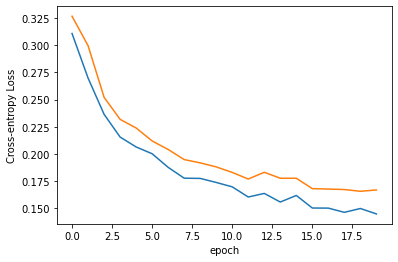

In [45]:
plt.plot(clf_test._score)
plt.plot(clf_test._score_val)

plt.xlabel("epoch")
plt.ylabel("Cross-entropy Loss")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

オレンジ:X_val, 青:X_train


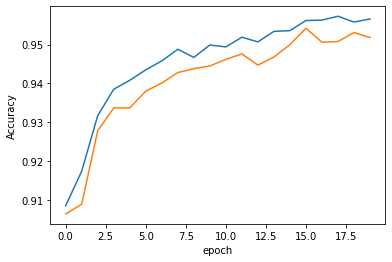

In [48]:
plt.plot(clf_test._accuracy)
plt.plot(clf_test._accuracy_val)

plt.xlabel("epoch")
plt.ylabel("Accuracy")
# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

## 【問題9】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。  

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。  
フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。  

以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。  

In [14]:
def _N_out_h(H, FH, pad, stride):
    # H:入力データの高さ、FH:フィルタの高さ
    return (1 + int((H + 2*pad - FH) / stride))

def _N_out_w(W, FW, pad, stride):
    # W:入力データの高さ、FW:フィルタの高さ
    return (1 + int((W + 2*pad - FW) / stride))

1.

入力サイズ : 144×144, 3チャンネル  
フィルタサイズ : 3×3, 6チャンネル  
ストライド : 1  
パディング : なし  

計算結果  
出力サイズ 142x142, 6チャンネル  
重み 162(3x6x3x3)   
バイアス 6  

In [16]:
h = _N_out_h(144, 3, 0, 1)
w = _N_out_w(144, 3, 0, 1)
print(h, w)

142 142


2.

入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし
    
計算結果
出力サイズ 58x58, 48チャンネル
重み 10368(24x48x3x3)
バイアス 48

In [20]:
h = _N_out_h(60, 3, 0, 1)
w = _N_out_w(60, 3, 0, 1)
print(h, w)

58 58


3.

入力サイズ : 20×20, 10チャンネル  
フィルタサイズ: 3×3, 20チャンネル  
ストライド : 2  
パディング : なし  

計算結果  
出力サイズ 9x9, 20チャンネル  
重み 1800(10x20x3x3)  
バイアス 20

In [24]:
h = _N_out_h(20, 3, 0, 2)
w = _N_out_w(20, 3, 0, 2)
print(h, w)

9 9
